In [1]:
import numpy as np
import scipy.constants as sc
from scipy.integrate import solve_ivp, odeint
import matplotlib.pyplot as plt

In [2]:
#Constats
#Material
decanol1 = {'m':158.285, #amu
            'n_atom':33, 
            'DOF':99,
            'rho_l':830, #kg m^-3
            'c_l': 1600, #J kg^-1 K^-1
            'p*':1.3, #Pa
            'T*':298.15, #K
            'deltaH_vap':8.1*10**4 #J / mole
        }

#Chamber
chamber = {'Volume V_ch':10**(-2), #m^3
           'Surface area A_ch':0.7, #m^2
           'Pumping speed S_p':50*10**(-3), #m^3 s^-1
           'wall leak flux j_w':3*10**12, #m^-2 s^-1
           'liquid vol V_l':3*10**(-6), #m^3
           'surface area A_l':4.66*10**(-4) #m^2
        }

#Set parameters in use
m, n_atom, D, rho_l, c_l, p_star, T_star, deltaH_vap = decanol1.values()
V_ch, A_ch, S_p, j_w, V_l, A_l = chamber.values()
t_s = 10**3 #tau_s


In [93]:

# Set parameters
m, n_atom, DOF, rho_l, c_l, p_star, T_star, deltaH_vap = decanol1.values()
V_ch, A_ch, S_p, j_w, V_l, A_l = chamber.values()
t_s = 10**3  # tau_s in seconds
m = m * 1.66053907 * 10**(-27)  # Convert mass from atomic units to kg
# DOF = 0
# Starting values
T_l = 273.15 # Liquid temperature in K
P_v = 1.2    # Vapor pressure in Pa (initial 0.7 bar)
T_v = 273.15 + 35 # Vapor temperature in K GOOD!!!

def delta_valve(t):
    if t > 10:
        return 0
    else:
        return 1

def P_sat(T): #GOOD!
    return p_star * np.exp( - deltaH_vap / (sc.k * sc.N_A) * (1/T - 1/T_star) )

def j_ev(T_l, P_v):  #GOOD !!
    sigma_e = (P_sat(T_l)/P_v) * np.exp( (DOF +4) * (1 - T_v/T_l) ) * (T_v/T_l) ** (DOF+4)
    sigma_c = np.sqrt( T_v/T_l ) * np.exp( -(DOF+4) * (1 - T_v/T_l) ) * (T_v/T_l) ** (-(DOF + 4))

    return np.sqrt( 1/ (2 * np.pi * m * sc.k) ) * ( sigma_e * P_sat(T_l) / np.sqrt( T_l ) - sigma_c * P_v / np.sqrt( T_l ) )

def system(y, time):
    P_v, T_l, V_l = y
    jev = j_ev(T_l, P_v)

    dp_vdt = A_l / V_ch * sc.k * T_v * jev + A_ch / V_ch * sc.k * T_v * j_w - S_p / V_ch * P_v * delta_valve(time)

    dT_ldt = - A_l * deltaH_vap / ( sc.N_A * rho_l * V_l * c_l ) * jev + ( T_v - T_l) / t_s

    dV_ldt = - m / ( rho_l) * A_l  * jev

    return [dp_vdt, dT_ldt, dV_ldt]


In [94]:
time = np.linspace(0, 10**4, 100000)
solution = odeint(system, y0=np.array([P_v, T_l, V_l]), t=time)

Text(0.5, 0.01, 'Time [s]')

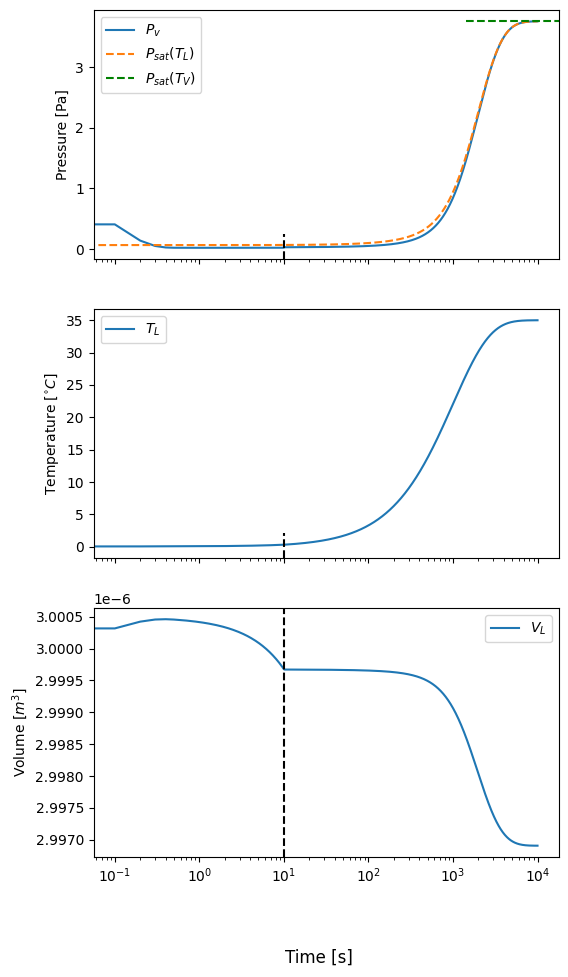

In [160]:
fig, ax = plt.subplots(3,1, figsize=(6,11),sharex=True)
ax[0].plot(time,solution[:,0], label=r"$P_{v}$")
ax[0].plot(time,P_sat(solution[:,1]), label=r"$P_{sat}(T_{L})$", linestyle="--")
ax[0].set_xscale("log")
ax[0].set_ylabel("Pressure [Pa]")
# ax[0].grid()
ax[0].axvline(x=10, color='black', linestyle='--',ymin=0, ymax=0.1)
ax[0].axhline(y=P_sat(T_v), color="g", linestyle="--", xmin=0.8,xmax=1, label=r"$P_{sat}(T_{V})$")
ax[0].legend()

ax[1].plot(time,solution[:,1]-273.15, label=r"$T_L$")
ax[1].set_xscale("log")
ax[1].set_ylabel(r"Temperature [$^{\circ}C$]")
# ax[1].grid()
ax[1].axvline(x=10, color='black', linestyle='--',ymin=0, ymax=0.1)
ax[1].legend()

ax[2].plot(time,solution[:,2], label=r"$V_L$")
ax[2].set_xscale("log")
ax[2].set_ylabel(r"Volume [$m^{3}$]")
# ax[2].grid()
ax[2].axvline(x=10, color='black', linestyle='--')
ax[2].legend()

fig.supxlabel("Time [s]")


In [50]:

pressure = [P_v]
liquid_temparature = [T_l]
liquid_volume = [V_l]
time = np.linspace(10**(-1), 10**4, 1000000)

for t in range(len(time)):
    #Calc j_ev
    
    # print(t, time[t])
    delta = 0.01
    #Calculate change
    # dp = A_l/V_ch * sc.k * T_v * j + A_ch/V_ch * sc.k * T_v * j_w - S_p/V_ch * P_v * valve
    # dT =  - ( A_l * deltaH_vap) / ( sc.N_A * rho_l * V_l * c_l) * j + ( T_v - T_l) / t_s
    # dV = - m/(rho_l * A_l) * j
    
    dp, dT, dV = system([pressure[-1], liquid_temparature[-1], liquid_volume[-1]], t)
    # print(P_v,T_l,V_l)
    if t == 1:
        print(pressure,liquid_temparature,liquid_volume)
    #Add change to value
    P_v += dp*delta
    T_l += dT*delta
    V_l += dV*delta

    #Add to list
    pressure.append(P_v)
    liquid_temparature.append(T_l)
    liquid_volume.append(V_l)


[1.2, 1.1400000089343838] [273.15, 273.15035] [3e-06, 5869698742.872349]


KeyboardInterrupt: 

In [148]:
from scipy.optimize import curve_fit

def expfunc(x, a, b ,c):
    return a* np.exp(b * x ) + c

popt, pcov = curve_fit(expfunc, time, solution[:,1], p0=[100,-11,273+35], maxfev=10000 )
print(popt, np.diag(pcov))

C:\Users\andre\AppData\Local\Temp\ipykernel_16260\2182396933.py:4: RuntimeWarning: overflow encountered in exp
  return a* np.exp(b * x ) + c
C:\Users\andre\AppData\Local\Temp\ipykernel_16260\2182396933.py:4: RuntimeWarning: overflow encountered in multiply
  return a* np.exp(b * x ) + c


[-3.49511654e+01 -9.92714676e-04  3.08137803e+02] [1.06335650e-07 2.29321860e-16 4.48269915e-09]


308.1378026883232


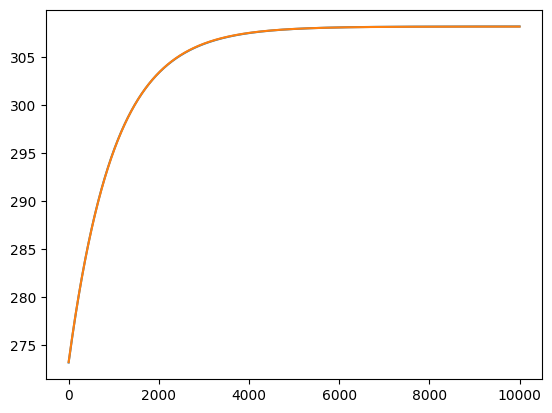

In [150]:
plt.plot(time,solution[:,1])
plt.plot(time, expfunc(time,*popt))
print(popt[-1])